In this note we are going to Deploy a model to predict Adult income based on the given dataset

In [667]:
import pandas as pd
import numpy as np
from flask import Flask
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


In [668]:
income_df=pd.read_csv("adult.csv")

In [669]:
income_df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


let's reduce some noise in the dataset if there's any

In [670]:
income_df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

no null values still need to check the missing

In [671]:
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   fnlwgt           32561 non-null  int64 
 3   education        32561 non-null  object
 4   educational-num  32561 non-null  int64 
 5   marital-status   32561 non-null  object
 6   occupation       32561 non-null  object
 7   relationship     32561 non-null  object
 8   race             32561 non-null  object
 9   gender           32561 non-null  object
 10  capital-gain     32561 non-null  int64 
 11  capital-loss     32561 non-null  int64 
 12  hours-per-week   32561 non-null  int64 
 13  native-country   32561 non-null  object
 14  income           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [672]:
income_df["age"].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87], dtype=int64)

let's categorize them into 1-10 <br> only because we are going to get user input 
| AGE| Category |
|----------------------|----------|
| 1 - 10              | 1        |
| 11 - 20             | 2        |
| 21 - 30             | 3        |
| 31 - 40             | 4        |
| 41 - 50             | 5        |
| 51 - 60             | 6        |
| 61 - 70             | 7        |
| 71 - 80             | 8        |
| 81 - 90             | 9        |
| 91+                 | 10       |


In [673]:
income_df["workclass"].unique() #need to encode and replace '?'

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [674]:
income_df["fnlwgt"]

0         77516
1         83311
2        215646
3        234721
4        338409
          ...  
32556    257302
32557    154374
32558    151910
32559    201490
32560    287927
Name: fnlwgt, Length: 32561, dtype: int64

The fnlwgt (Final Weight) column in the Adult Income Dataset represents a sampling weight assigned by the Census Bureau. 
#doesn't contribute much to the prediction so, it's best to drop the column

In [675]:
income_df.drop(["fnlwgt"],inplace=True,axis=1)

In [676]:
income_df["education"].unique() #need to encode the values as there's a heirarchy we can assign value based on it

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

| Short Form     | Full Form                                      |
|---------------|----------------------------------------------|
| Preschool     | Preschool Education                         |
| 1st-4th       | 1st to 4th Grade Completed                  |
| 5th-6th       | 5th to 6th Grade Completed                  |
| 7th-8th       | 7th to 8th Grade Completed                  |
| 9th           | 9th Grade Completed                         |
| 10th          | 10th Grade Completed                        |
| 11th          | 11th Grade Completed                        |
| 12th          | 12th Grade Completed                        |
| HS-grad       | High School Graduate                        |
| Some-college  | Some College, No Degree                     |
| Assoc-voc     | Associate Degree (Vocational)               |
| Assoc-acdm    | Associate Degree (Academic)                 |
| Bachelors     | Bachelor's Degree                           |
| Masters       | Master's Degree                             |
| Prof-school   | Professional School Degree (e.g., Medicine, Law) |
| Doctorate     | Doctoral Degree (Ph.D.)                     |


In [677]:
income_df[["education","educational-num"]].sort_values(by="educational-num")

,education,educational-num
22940,Preschool,1
13248,Preschool,1
21370,Preschool,1
25943,Preschool,1
21388,Preschool,1
...,...,...
10647,Doctorate,16
12074,Doctorate,16
28758,Doctorate,16
4597,Doctorate,16


In [678]:
income_df["educational-num"].unique() 

array([13,  9,  7, 14,  5, 10, 12, 11,  4, 16, 15,  3,  6,  2,  1,  8],
      dtype=int64)

As the education-num column represent the heirarchy in the education column we can drop the column education but we should note the order for customer input indentification

In [679]:
income_df[['education', 'educational-num']].drop_duplicates().sort_values(by='educational-num').reset_index(drop=True).values

array([[' Preschool', 1],
       [' 1st-4th', 2],
       [' 5th-6th', 3],
       [' 7th-8th', 4],
       [' 9th', 5],
       [' 10th', 6],
       [' 11th', 7],
       [' 12th', 8],
       [' HS-grad', 9],
       [' Some-college', 10],
       [' Assoc-voc', 11],
       [' Assoc-acdm', 12],
       [' Bachelors', 13],
       [' Masters', 14],
       [' Prof-school', 15],
       [' Doctorate', 16]], dtype=object)

In [680]:
#let's export this data 
import json
temp_array=income_df[['education', 'educational-num']].drop_duplicates().sort_values(by='educational-num').reset_index(drop=True).values
education_category={}
for i,j in temp_array:
    education_category[i.strip()]=j
with open("education_category.json", "w") as f:
    json.dump(education_category, f, indent=4) 

In [681]:
income_df.drop("education",inplace=True,axis=1)

In [682]:
income_df["marital-status"].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

| Marital Status         | Expanded Form                                             |
|------------------------|-----------------------------------------------------------|
| Never-married         | Never Married (Single)                                    |
| Married-civ-spouse    | Married (Civilian Spouse)                                |
| Married-AF-spouse     | Married to an Armed Forces Spouse                        |
| Married-spouse-absent | Married, but Spouse is Absent (Separated, Unofficial)    |
| Separated             | Legally Separated                                        |
| Divorced             | Divorced                                                 |
| Widowed              | Widowed (Lost Spouse)                                    |


we don't need this much detail in marital status to predict the income of the individual as the income is not calculated as a total of partners
so, we can reduce the values to single,married

In [683]:
marital_map = {
    " Never-married": "single",
    " Divorced": "single",
    " Separated": "single",
    " Married-spouse-absent": "single",
    " Widowed": "single",
    " Married-civ-spouse": "married",
    " Married-AF-spouse": "married"
}
income_df["marital_status_simplified"] = income_df["marital-status"].map(marital_map)
#we should also encode this 
income_df.drop("marital-status",inplace=True,axis=1)

In [684]:
income_df["occupation"].unique()
#need to encode and replace '?'

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [685]:
income_df["race"].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

we don't wanna create a racist model. let's assume the salary providers are racists the salary might differ based on race but we are going to ignore it for now as later we will be getting input from people

In [686]:
income_df.drop("race",axis=1,inplace=True)

In [687]:
income_df["relationship"].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

we are dropping relationship column we already have marital status though the relationship column might gives us the income level of the individual it is not much pratical also If we are taking user input for prediction, the relationship column can be ambiguous and confusing. Users may not clearly understand categories like "Other-relative" or "Not-in-family".

In [688]:
income_df.drop("relationship",inplace=True,axis=1)

In [689]:
income_df["gender"].unique() 
#we need to strip

array([' Male', ' Female'], dtype=object)

In [690]:
income_df["capital-gain"].unique()

array([ 2174,     0, 14084,  5178,  5013,  2407, 14344, 15024,  7688,
       34095,  4064,  4386,  7298,  1409,  3674,  1055,  3464,  2050,
        2176,   594, 20051,  6849,  4101,  1111,  8614,  3411,  2597,
       25236,  4650,  9386,  2463,  3103, 10605,  2964,  3325,  2580,
        3471,  4865, 99999,  6514,  1471,  2329,  2105,  2885, 25124,
       10520,  2202,  2961, 27828,  6767,  2228,  1506, 13550,  2635,
        5556,  4787,  3781,  3137,  3818,  3942,   914,   401,  2829,
        2977,  4934,  2062,  2354,  5455, 15020,  1424,  3273, 22040,
        4416,  3908, 10566,   991,  4931,  1086,  7430,  6497,   114,
        7896,  2346,  3418,  3432,  2907,  1151,  2414,  2290, 15831,
       41310,  4508,  2538,  3456,  6418,  1848,  3887,  5721,  9562,
        1455,  2036,  1831, 11678,  2936,  2993,  7443,  6360,  1797,
        1173,  4687,  6723,  2009,  6097,  2653,  1639, 18481,  7978,
        2387,  5060], dtype=int64)

In [691]:
income_df[(income_df["capital-gain"] >0) & (income_df["capital-gain"] <3000)]["income"].unique()

array([' <=50K'], dtype=object)

In [692]:
income_df[(income_df["capital-gain"]==0)]["income"].unique()

array([' <=50K', ' >50K'], dtype=object)

In [693]:
income_df[(income_df["capital-gain"] >0) & (income_df["capital-gain"] >=50000)]["income"].unique()

array([' >50K'], dtype=object)

when the capital-gain is not 0 and <=3000 the income is always <=50k and when the capital-gain is >=50000 <br>
Obviously if there's not much loss the income is >50k
based on this let's split the data into zero, low, medium, high

In [694]:
income_df["capital-loss"].unique()

array([   0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816,
       1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721,
       2051, 2377, 1669, 2352, 1672,  653, 2392, 1504, 2001, 1590, 1651,
       1628, 1848, 1740, 2002, 1579, 2258, 1602,  419, 2547, 2174, 2205,
       1726, 2444, 1138, 2238,  625,  213, 1539,  880, 1668, 1092, 1594,
       3004, 2231, 1844,  810, 2824, 2559, 2057, 1974,  974, 2149, 1825,
       1735, 1258, 2129, 2603, 2282,  323, 4356, 2246, 1617, 1648, 2489,
       3770, 1755, 3683, 2267, 2080, 2457,  155, 3900, 2201, 1944, 2467,
       2163, 2754, 2472, 1411], dtype=int64)

In [695]:
income_df[(income_df["capital-gain"] ==0) & (income_df["capital-loss"]>3000)]["income"].unique()

array([' >50K', ' <=50K'], dtype=object)

In [696]:
income_df[(income_df["capital-gain"] ==0) & (income_df["capital-loss"]>1000)]["income"].unique()

array([' <=50K', ' >50K'], dtype=object)

In [697]:
income_df[(income_df["capital-gain"] ==0) & (income_df["capital-loss"]<1000)]["income"].unique()

array([' <=50K', ' >50K'], dtype=object)

we can drop the capital-loss as it complicates the input from the user and it doesn't affect the result much individually but it's not the right way in case of predicting with a dataset it's wise to keep the column

In [698]:
income_df.drop("capital-loss",axis=1,inplace=True)

In [699]:
def categorize_capital_gain(value):
    if value == 0:
        return "zero"
    elif value < 3000:
        return "low"
    elif value < 50000:
        return "medium"
    else:
        return "High"

income_df["capital-gain-category"] = income_df["capital-gain"].apply(categorize_capital_gain)


In [700]:
income_df.drop("capital-gain",inplace=True,axis=1)

In [701]:
income_df["hours-per-week"].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55,
       48, 58, 32, 70,  2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65,  1, 10,
       34, 75, 98, 33, 54,  8,  6, 64, 19, 18, 72,  5,  9, 47, 37, 21, 26,
       14,  4, 59,  7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84,  3, 17,
       68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95], dtype=int64)

let's categorize them into 1-10 <br>
| Hours Per Week Range | Category |
|----------------------|----------|
| 1 - 10              | 1        |
| 11 - 20             | 2        |
| 21 - 30             | 3        |
| 31 - 40             | 4        |
| 41 - 50             | 5        |
| 51 - 60             | 6        |
| 61 - 70             | 7        |
| 71 - 80             | 8        |
| 81 - 90             | 9        |
| 91+                 | 10       |


In [702]:
income_df[income_df["native-country"]==' ?'].__len__

<bound method DataFrame.__len__ of        age          workclass  ...  marital_status_simplified capital-gain-category
14      40            Private  ...                    married                  zero
38      31            Private  ...                    married                  zero
51      18            Private  ...                     single                  zero
61      32                  ?  ...                     single                  zero
93      30            Private  ...                    married                  zero
...    ...                ...  ...                        ...                   ...
32449   44       Self-emp-inc  ...                    married                  zero
32469   58       Self-emp-inc  ...                     single                  zero
32492   42   Self-emp-not-inc  ...                     single                  zero
32510   39            Private  ...                    married                  zero
32525   81                  ?  ...       

In [703]:
income_df[(income_df["occupation"]==' ?')].__len__

<bound method DataFrame.__len__ of        age workclass  ...  marital_status_simplified capital-gain-category
27      54         ?  ...                    married                  zero
61      32         ?  ...                     single                  zero
69      25         ?  ...                     single                  zero
77      67         ?  ...                    married                  zero
106     17         ?  ...                     single                medium
...    ...       ...  ...                        ...                   ...
32530   35         ?  ...                    married                  zero
32531   30         ?  ...                     single                  zero
32539   71         ?  ...                    married                  zero
32541   41         ?  ...                     single                  zero
32542   72         ?  ...                    married                  zero

[1843 rows x 10 columns]>

In [704]:
income_df[(income_df["workclass"]==' ?')].__len__

<bound method DataFrame.__len__ of        age workclass  ...  marital_status_simplified capital-gain-category
27      54         ?  ...                    married                  zero
61      32         ?  ...                     single                  zero
69      25         ?  ...                     single                  zero
77      67         ?  ...                    married                  zero
106     17         ?  ...                     single                medium
...    ...       ...  ...                        ...                   ...
32530   35         ?  ...                    married                  zero
32531   30         ?  ...                     single                  zero
32539   71         ?  ...                    married                  zero
32541   41         ?  ...                     single                  zero
32542   72         ?  ...                    married                  zero

[1836 rows x 10 columns]>

we need to analyse all the category and their distribution to replace these missing column properly but it's very time consuming but can be done as this is just a sample work project let's replace it with mode for all (not recommended for realtime purposes)

In [705]:
income_df.replace(' ?',np.nan,inplace=True)
income_df.fillna(income_df.mode().iloc[0],inplace=True)

okay, we have analysed the data now let's encode it for testing. <br>
let's create a pipeline for preprocessing

In [706]:
income_df

,age,workclass,educational-num,occupation,gender,hours-per-week,native-country,income,marital_status_simplified,capital-gain-category
0,39,State-gov,13,Adm-clerical,Male,40,United-States,<=50K,single,low
1,50,Self-emp-not-inc,13,Exec-managerial,Male,13,United-States,<=50K,married,zero
2,38,Private,9,Handlers-cleaners,Male,40,United-States,<=50K,single,zero
3,53,Private,7,Handlers-cleaners,Male,40,United-States,<=50K,married,zero
4,28,Private,13,Prof-specialty,Female,40,Cuba,<=50K,married,zero
...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Tech-support,Female,38,United-States,<=50K,married,zero
32557,40,Private,9,Machine-op-inspct,Male,40,United-States,>50K,married,zero
32558,58,Private,9,Adm-clerical,Female,40,United-States,<=50K,single,zero
32559,22,Private,9,Adm-clerical,Male,20,United-States,<=50K,single,zero


why we need to encode manually? As, we are going to get input from the user we need to know which column is getting encoded to which value.

In [707]:
#encoding age
def encode_age(df: pd.DataFrame) -> np.ndarray:
    print("Encoding age...")
    age = df.iloc[:, 0] 
    encoded = np.select(
        [age < 10, age < 20, age < 30, age < 40, age < 50, 
         age < 60, age < 70, age < 80, age < 90],
        [1, 2, 3, 4, 5, 6, 7, 8, 9], default=10)
    return encoded.reshape(-1, 1)

#encoding hours
def encode_hours(df: pd.DataFrame) -> np.ndarray:
    print("Encoding hours worked per week...")
    hours = df.iloc[:, 0]
    encoded = np.select(
        [hours < 10, hours < 20, hours < 30, hours < 40, hours < 50, 
         hours < 60, hours < 70, hours < 80, hours < 90],
        [1, 2, 3, 4, 5, 6, 7, 8, 9], default=10)
    return encoded.reshape(-1, 1)

#encoding capital_gain
def encode_capital_gain(df: pd.DataFrame) -> np.ndarray:
    print("Encoding capital gain...")
    gains = df.iloc[:, 0]
    encoded = np.select([gains == "low", gains == "medium", gains == "high"], 
                        [1, 2, 3], default=0)
    return encoded.reshape(-1, 1)

#encoding gender
def encode_gender(df: pd.DataFrame) -> np.ndarray:
    print("Encoding gender...")
    gender = df.iloc[:, 0].str.strip().str.lower()
    encoded = np.select([gender == "male", gender == "female"], [1, 2], default=0)
    return encoded.reshape(-1, 1)

#encoding workclass
def encode_workclass(df: pd.DataFrame) -> np.ndarray:
    print("Encoding workclass...")
    workclass = df.iloc[:, 0].str.strip().str.lower()
    mapping = {
        'private': 1, 'self-emp-not-inc': 2, 'self-emp-inc': 3, 
        'federal-gov': 4, 'local-gov': 5, 'state-gov': 6, 
        'without-pay': 7, 'never-worked': 8
    }
    encoded = workclass.map(mapping).fillna(0).astype(int)
    return encoded.to_numpy().reshape(-1, 1)

#encoding marital status
def encode_marital_status(df: pd.DataFrame) -> np.ndarray:
    print("Encoding marital status...")
    status = df.iloc[:, 0].str.strip().str.lower()
    encoded = np.select([status == "single", status == "married"], [1, 2], default=0)
    return encoded.reshape(-1, 1)

#encoding occupation
def encode_occupation(df: pd.DataFrame) -> np.ndarray:
    print("Encoding occupation...")
    occupation = df.iloc[:, 0].str.strip().str.lower()
    occupation_mapping = {
        'adm-clerical': 1, 'exec-managerial': 2, 'handlers-cleaners': 3, 
        'prof-specialty': 4, 'other-service': 5, 'sales': 6, 
        'craft-repair': 7, 'transport-moving': 8, 'farming-fishing': 9, 
        'machine-op-inspct': 10, 'tech-support': 11, 'protective-serv': 12, 
        'armed-forces': 13, 'priv-house-serv': 14
    }
    encoded = occupation.map(occupation_mapping).fillna(0).astype(int)
    return encoded.to_numpy().reshape(-1, 1)

#encoding country
def encode_country(df: pd.DataFrame) -> np.ndarray:
    print("Encoding country...")
    country = df.iloc[:, 0].str.strip().str.lower()
    country_mapping = {
        'united-states': 1, 'cuba': 2, 'jamaica': 3, 'india': 4, 'mexico': 5, 
        'south': 6, 'puerto-rico': 7, 'honduras': 8, 'england': 9, 'canada': 10, 
        'germany': 11, 'iran': 12, 'philippines': 13, 'italy': 14, 'poland': 15, 
        'columbia': 16, 'cambodia': 17, 'thailand': 18, 'ecuador': 19, 'laos': 20, 
        'taiwan': 21, 'haiti': 22, 'portugal': 23, 'dominican-republic': 24, 
        'el-salvador': 25, 'france': 26, 'guatemala': 27, 'china': 28, 'japan': 29, 
        'yugoslavia': 30, 'peru': 31, 'outlying-us(guam-usvi-etc)': 32, 'scotland': 33, 
        'trinidad&tobago': 34, 'greece': 35, 'nicaragua': 36, 'vietnam': 37, 'hong': 38, 
        'ireland': 39, 'hungary': 40, 'holand-netherlands': 41
    }
    encoded = country.map(country_mapping).fillna(0).astype(int)
    return encoded.to_numpy().reshape(-1, 1)

#encoding encode income
def encode_income(df: pd.DataFrame) -> np.ndarray:
    print("Encoding income...")
    income = df.iloc[:, 0].str.strip().str.lower()
    encoded = np.select([income == "<=50k", income == ">50k"], [0, 1], default=2)
    return encoded.reshape(-1, 1)



In [708]:
age_pipeline = Pipeline([("encoder", FunctionTransformer(encode_age))])
workclass_pipeline = Pipeline([("encoder", FunctionTransformer(encode_workclass))])
occupation_pipeline = Pipeline([("encoder", FunctionTransformer(encode_occupation))])
gender_pipeline = Pipeline([("encoder", FunctionTransformer(encode_gender))])
workhours_pipeline = Pipeline([("encoder", FunctionTransformer(encode_hours))])
capital_gain_pipeline = Pipeline([("encoder", FunctionTransformer(encode_capital_gain))])
marital_status_pipeline = Pipeline([("encoder", FunctionTransformer(encode_marital_status))])
country_pipeline = Pipeline([("encoder", FunctionTransformer(encode_country))])
income_pipeline = Pipeline([("encoder", FunctionTransformer(encode_income))])

In [709]:
xencoder = ColumnTransformer(transformers=[
    ("age_encoder", age_pipeline, ["age"]),
    ("gender_encoder", gender_pipeline, ["gender"]),
    ("marital_status_encoder", marital_status_pipeline, ["marital_status_simplified"]),
    ("occupation_encoder", occupation_pipeline, ["occupation"]),
    ("workhours_encoder", workhours_pipeline, ["hours-per-week"]),
    ("workclass_encoder", workclass_pipeline, ["workclass"]),
    ("capital_gain_encoder", capital_gain_pipeline, ["capital-gain-category"]),
    ("country_encoder", country_pipeline, ["native-country"]) ], remainder="passthrough")

In [710]:
xencoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('age_encoder',
                                 Pipeline(steps=[('encoder',
                                                  FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                 ['age']),
                                ('gender_encoder',
                                 Pipeline(steps=[('encoder',
                                                  FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                 ['gender']),
                                ('marital_status_encoder',
                                 Pipeline(steps=[(...
                                                  FunctionTransformer(func=<function encode_workclass at 0x00000243D07094E0>))]),
                                 ['workclass']),
                                ('capital_gain_encoder',
                                 Pipeline(steps=[('encoder',
                                                  FunctionTransformer(func=<function encode_capital_gain at 0x00000243D4519940>))]),
                                 ['capital-gain-category']),
                                ('country_encoder',
                                 Pipeline(steps=[('encoder',
                                                  FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                 ['native-country'])])

In [711]:
pd.DataFrame(xencoder.fit_transform(income_df.drop("income",axis=1)),columns=["age","gender","marital status","occupation","work hours","workclass","capital gain","country","education"])

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


,age,gender,marital status,occupation,work hours,workclass,capital gain,country,education
0,4,1,1,1,5,6,1,1,13
1,6,1,2,2,2,2,0,1,13
2,4,1,1,3,5,1,0,1,9
3,6,1,2,3,5,1,0,1,7
4,3,2,2,4,5,1,0,2,13
...,...,...,...,...,...,...,...,...,...
32556,3,2,2,11,4,1,0,1,12
32557,5,1,2,10,5,1,0,1,9
32558,6,2,1,1,5,1,0,1,9
32559,3,1,1,1,3,1,0,1,9


In [712]:
income_df

,age,workclass,educational-num,occupation,gender,hours-per-week,native-country,income,marital_status_simplified,capital-gain-category
0,39,State-gov,13,Adm-clerical,Male,40,United-States,<=50K,single,low
1,50,Self-emp-not-inc,13,Exec-managerial,Male,13,United-States,<=50K,married,zero
2,38,Private,9,Handlers-cleaners,Male,40,United-States,<=50K,single,zero
3,53,Private,7,Handlers-cleaners,Male,40,United-States,<=50K,married,zero
4,28,Private,13,Prof-specialty,Female,40,Cuba,<=50K,married,zero
...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Tech-support,Female,38,United-States,<=50K,married,zero
32557,40,Private,9,Machine-op-inspct,Male,40,United-States,>50K,married,zero
32558,58,Private,9,Adm-clerical,Female,40,United-States,<=50K,single,zero
32559,22,Private,9,Adm-clerical,Male,20,United-States,<=50K,single,zero


okay now we know the order of the input let's complete the pipeline by adding the model

In [713]:
model=Pipeline(steps=[("encoder",xencoder),("decision_tree",DecisionTreeClassifier(random_state=42))])

In [722]:
yencoder=ColumnTransformer(transformers=[("income_encoder",income_pipeline,["income"])])

In [715]:
model

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                  ['age']),
                                                 ('gender_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                                  ['gender']),
                                                 ('marital_status...
                                                 ('capital_gain_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_capital_gain at 0x00000243D4519940>))]),
                                                  ['capital-gain-category']),
                                                 ('country_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                  ['native-country'])])),
                ('decision_tree', DecisionTreeClassifier(random_state=42))])

we need to find the best params for our model.so, we are going to play a little with GridsearchCV

In [716]:
#hyperparams
grid={"decision_tree__criterion":["gini","entropy","log_loss"],
      "decision_tree__splitter":["best","random"],
      "decision_tree__max_depth":[10,20,5],
      "decision_tree__max_features":["sqrt","log2"]}

In [726]:
x=income_df.drop("income",axis=1)
y=income_df[["income"]]

In [720]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
32556,<=50K
32557,>50K
32558,<=50K
32559,<=50K


In [731]:
y=pd.DataFrame(yencoder.fit_transform(y).flatten(),columns=["income"])

Encoding income...


In [732]:
y

,income
0,0
1,0
2,0
3,0
4,0
...,...
32556,0
32557,1
32558,0
32559,0


In [733]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.75)

In [734]:
GridSearchCV(model,grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=2)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                                         ['age']),
                                                                        ('gender_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),...
                                                                                          FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                                         ['native-country'])])),
                                       ('decision_tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decision_tree__criterion': ['gini', 'entropy',
                                                      'log_loss'],
                         'decision_tree__max_depth': [10, 20, 5],
                         'decision_tree__max_features': ['sqrt', 'log2'],
                         'decision_tree__splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [735]:
searchcv=GridSearchCV(model,grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=2)

In [736]:
searchcv.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                                         ['age']),
                                                                        ('gender_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),...
                                                                                          FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                                         ['native-country'])])),
                                       ('decision_tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decision_tree__criterion': ['gini', 'entropy',
                                                      'log_loss'],
                         'decision_tree__max_depth': [10, 20, 5],
                         'decision_tree__max_features': ['sqrt', 'log2'],
                         'decision_tree__splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [737]:
searchcv.best_params_

{'decision_tree__criterion': 'gini',
 'decision_tree__max_depth': 10,
 'decision_tree__max_features': 'sqrt',
 'decision_tree__splitter': 'best'}

In [739]:
bestmodel=searchcv.best_estimator_

In [746]:
bestmodel.fit(x_train,y_train)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                  ['age']),
                                                 ('gender_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                                  ['gender']),
                                                 ('marital_status...
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_capital_gain at 0x00000243D4519940>))]),
                                                  ['capital-gain-category']),
                                                 ('country_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                  ['native-country'])])),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=10, max_features='sqrt',
                                        random_state=42))])

In [748]:
y_preds=bestmodel.predict(x_test)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


In [764]:
bestmodel.score(x_test,y_test)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


0.837612086967203

In [765]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
confusion_matrix(y_preds,y_test)

array([[5784,  892],
       [ 430, 1035]], dtype=int64)

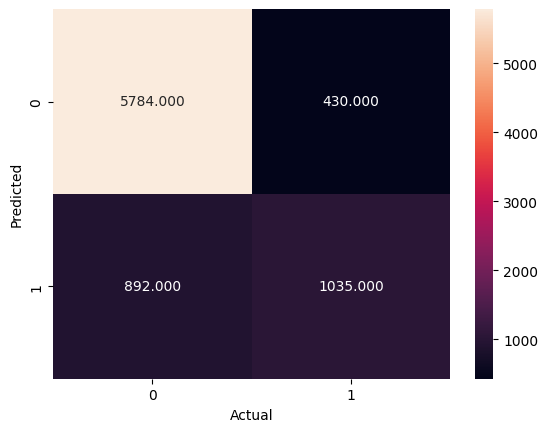

In [773]:
sns.heatmap(confusion_matrix(y_test["income"],y_preds),annot=True,xticklabels=["0","1"],yticklabels=["0","1"],fmt=".3f")
plt.xlabel("Actual")
plt.ylabel("Predicted");

lets try using RandomForestClassifier as the DescisionTree's results are a bit average

In [774]:
from sklearn.ensemble import RandomForestClassifier

In [786]:
grid2={"random_classifier__n_estimators":[100,200,300],
       "random_classifier__criterion":["gini", "entropy", "log_loss"],
       "random_classifier__max_depth":[10,20,30],
       "random_classifier__max_features":["sqrt", "log2", None],}

In [782]:
model1=Pipeline(steps=[("encoder",xencoder),("random_classifier",RandomForestClassifier())])

In [783]:
model1

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                  ['age']),
                                                 ('gender_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                                  ['gender']),
                                                 ('marital_status...
                                                  ['workclass']),
                                                 ('capital_gain_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_capital_gain at 0x00000243D4519940>))]),
                                                  ['capital-gain-category']),
                                                 ('country_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                  ['native-country'])])),
                ('random_classifier', RandomForestClassifier())])

In [787]:
searchcv2=GridSearchCV(model1,grid2,verbose=1,n_jobs=-1)

In [788]:
searchcv2.fit(x_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


GridSearchCV(estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                                         ['age']),
                                                                        ('gender_encoder',
                                                                         Pipeline(steps=[('encoder',
                                                                                          FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                                                         ['gen...
                                                                                          FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                                         ['native-country'])])),
                                       ('random_classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'random_classifier__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                         'random_classifier__max_depth': [10, 20, 30],
                         'random_classifier__max_features': ['sqrt', 'log2',
                                                             None],
                         'random_classifier__n_estimators': [100, 200, 300]},
             verbose=1)

In [789]:
searchcv2.best_params_

{'random_classifier__criterion': 'gini',
 'random_classifier__max_depth': 10,
 'random_classifier__max_features': 'sqrt',
 'random_classifier__n_estimators': 300}

In [790]:
bestmodel2=searchcv2.best_estimator_

In [791]:
bestmodel2.fit(x_train,y_train)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_age at 0x00000243D0712200>))]),
                                                  ['age']),
                                                 ('gender_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_gender at 0x00000243D0708360>))]),
                                                  ['gender']),
                                                 ('marital_status...
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_capital_gain at 0x00000243D4519940>))]),
                                                  ['capital-gain-category']),
                                                 ('country_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   FunctionTransformer(func=<function encode_country at 0x00000243D0708540>))]),
                                                  ['native-country'])])),
                ('random_classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=300))])

In [792]:
y_preds2=bestmodel2.predict(x_test)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


In [793]:
bestmodel2.score(x_test,y_test)

Encoding age...
Encoding gender...
Encoding marital status...
Encoding occupation...
Encoding hours worked per week...
Encoding workclass...
Encoding capital gain...
Encoding country...


0.8480530647340622

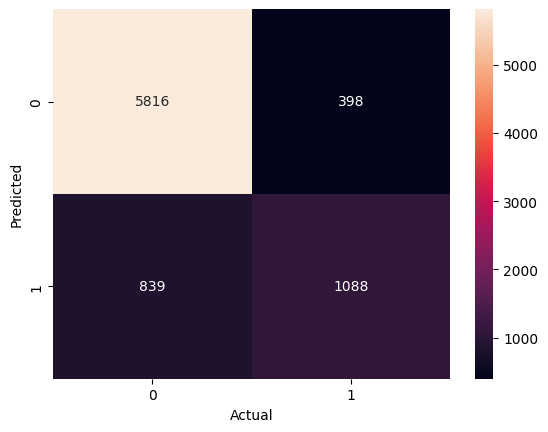

In [801]:
sns.heatmap(confusion_matrix(y_test["income"],y_preds2),annot=True,xticklabels=["0","1"],yticklabels=["0","1"],fmt="")
plt.xlabel("Actual")
plt.ylabel("Predicted");

Randomforestclassifier perfoms slights better which might be obivious cause forest is superset of trees okay for now let's go with this model for our project in realcase we should optimize further or choose different model

In [795]:
import pickle as pk

In [799]:
pk.dump(bestmodel2,open("adult_income_model.pkl","wb"))

we have now successfully created and exported our model

In [802]:
max(income_df["hours-per-week"])

99

small mistake we don't need to add the preprocessing model here cause we are going to get the data in the form we want from the user

In [809]:
pk.dump(bestmodel2['random_classifier'],open("adult_income_model.pkl","wb"))